<a href="https://colab.research.google.com/github/Syatiri/TB-Data-Mining/blob/main/TUGAS_BESAR_Apriori_and_Fp_Growth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth

In [2]:
groceries = pd.read_csv('Groceries_dataset.csv')
groceries.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk


In [3]:
groceries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
groceries.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(38765, 3)

In [5]:
all_transactions = [transaction[1]['itemDescription'].tolist() for transaction in list(groceries.groupby(['Member_number', 'Date']))]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
len(all_transactions)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


14963

# Data Preparation

In [7]:
all_transactions[0:10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['sausage', 'whole milk', 'semi-finished bread', 'yogurt'],
 ['whole milk', 'pastry', 'salty snack'],
 ['canned beer', 'misc. beverages'],
 ['sausage', 'hygiene articles'],
 ['soda', 'pickled vegetables'],
 ['frankfurter', 'curd'],
 ['sausage', 'whole milk', 'rolls/buns'],
 ['whole milk', 'soda'],
 ['beef', 'white bread'],
 ['frankfurter', 'soda', 'whipped/sour cream']]

In [8]:
#mengubah data transaksi ke dalam format one hot
trans_encoder = TransactionEncoder()
trans_encoder_matrix = trans_encoder.fit(all_transactions).transform(all_transactions)
trans_encoder_matrix = pd.DataFrame(trans_encoder_matrix, columns=trans_encoder.columns_)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
trans_encoder_matrix.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# Association Rules Implementation

### Helper Functions

In [10]:
def perform_rule_calculation(transact_items_matrix, rule_type="fpgrowth", min_support=0.001):

    start_time = 0
    total_execution = 0

    if(not rule_type=="fpgrowth"):
        start_time = time.time()
        rule_items = apriori(transact_items_matrix,
                       min_support=min_support,
                       use_colnames=True)
        total_execution = time.time() - start_time
        print("Computed Apriori!")

    else:
        start_time = time.time()
        rule_items = fpgrowth(transact_items_matrix,
                       min_support=min_support,
                       use_colnames=True)
        total_execution = time.time() - start_time
        print("Computed Fp Growth!")

    rule_items['number_of_items'] = rule_items['itemsets'].apply(lambda x: len(x))

    return rule_items, total_execution


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
def compute_association_rule(rule_matrix, metric="lift", min_thresh=1):
    rules = association_rules(rule_matrix,
                              metric=metric,
                              min_threshold=min_thresh)

    return rules

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# Plot Lift Vs Coverage(confidence)
def plot_metrics_relationship(rule_matrix, col1, col2):

    fit = np.polyfit(rule_matrix[col1], rule_matrix[col2], 1)
    fit_funt = np.poly1d(fit)
    plt.plot(rule_matrix[col1], rule_matrix[col2], 'yo', rule_matrix[col1],
    fit_funt(rule_matrix[col1]))
    plt.xlabel(col1)
    plt.ylabel(col2)
    plt.title('{} vs {}'.format(col1, col2))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
def compare_time_exec(algo1=list, alg2=list):

    execution_times = [algo1[1], algo2[1]]
    algo_names = (algo1[0], algo2[0])
    y=np.arange(len(algo_names))

    plt.bar(y,execution_times,color=['orange', 'blue'])
    plt.xticks(y,algo_names)
    plt.xlabel('Algorithms')
    plt.ylabel('Time')
    plt.title("Execution Time (seconds) Comparison")
    plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
val = {'name':12}
value = list(val.items())[0]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
value

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


('name', 12)

## Case n°1: Using Fp Growph Algorithm

In [16]:
fpgrowth_matrix, fp_growth_exec_time = perform_rule_calculation(trans_encoder_matrix)
print("Fp Growth execution took: {} seconds".format(fp_growth_exec_time))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Computed Fp Growth!
Fp Growth execution took: 0.2785935401916504 seconds


In [17]:
fpgrowth_matrix.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets,number_of_items
0,0.157923,(whole milk),1
1,0.085879,(yogurt),1
2,0.060349,(sausage),1
3,0.009490,(semi-finished bread),1
4,0.051728,(pastry),1


In [18]:
fpgrowth_matrix.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets,number_of_items
745,0.001403,"(yogurt, chewing gum)",2
746,0.001069,"(chewing gum, other vegetables)",2
747,0.001002,"(soda, chewing gum)",2
748,0.001069,"(whole milk, pasta)",2
749,0.001002,"(rolls/buns, seasonal products)",2


### Lift

In [19]:
fp_growth_rule_lift = compute_association_rule(fpgrowth_matrix)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
fp_growth_rule_lift.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,"(whole milk, rolls/buns)",(yogurt),0.013968,0.085879,0.001337,0.095694,1.114293,0.000137,1.010854,0.104023
1,"(whole milk, yogurt)",(rolls/buns),0.011161,0.110005,0.001337,0.119760,1.088685,0.000109,1.011083,0.082380
2,"(rolls/buns, yogurt)",(whole milk),0.007819,0.157923,0.001337,0.170940,1.082428,0.000102,1.015701,0.076751
3,(whole milk),"(rolls/buns, yogurt)",0.157923,0.007819,0.001337,0.008464,1.082428,0.000102,1.000650,0.090433
4,(rolls/buns),"(whole milk, yogurt)",0.110005,0.011161,0.001337,0.012151,1.088685,0.000109,1.001002,0.091530


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


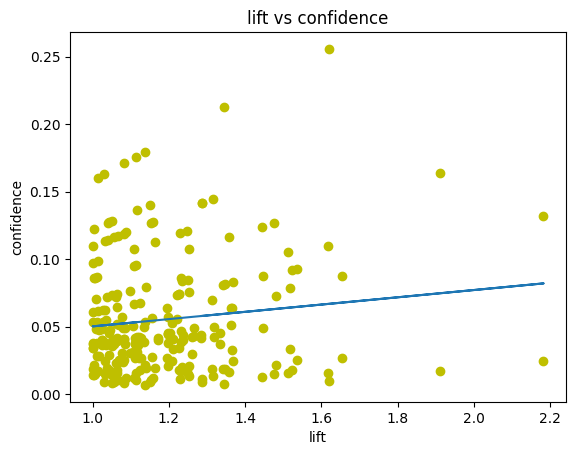

In [21]:
  plot_metrics_relationship(fp_growth_rule_lift, col1='lift', col2='confidence')

### Confidence

In [22]:
fp_growth_rule = compute_association_rule(fpgrowth_matrix, metric="confidence", min_thresh=0.2)
fp_growth_rule.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,"(sausage, yogurt)",(whole milk),0.005748,0.157923,0.001470,0.255814,1.619866,0.000563,1.131541,0.384877
1,"(sausage, rolls/buns)",(whole milk),0.005347,0.157923,0.001136,0.212500,1.345594,0.000292,1.069304,0.258214


## Case n°2: Using Apriori Algorithm

In [23]:
apriori_matrix, apriori_exec_time = perform_rule_calculation(trans_encoder_matrix, rule_type="apriori")
print("Apriori Execution took: {} seconds".format(apriori_exec_time))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Computed Apriori!
Apriori Execution took: 2.824995517730713 seconds


In [24]:
apriori_matrix.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets,number_of_items
0,0.004010,(Instant food products),1
1,0.021386,(UHT-milk),1
2,0.001470,(abrasive cleaner),1
3,0.001938,(artif. sweetener),1
4,0.008087,(baking powder),1


In [25]:
apriori_matrix.tail()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets,number_of_items
745,0.001136,"(sausage, whole milk, rolls/buns)",3
746,0.001002,"(whole milk, rolls/buns, soda)",3
747,0.001337,"(whole milk, rolls/buns, yogurt)",3
748,0.001069,"(whole milk, sausage, soda)",3
749,0.001470,"(whole milk, sausage, yogurt)",3


### Lift  

In [26]:
apriori_rule_lift = compute_association_rule(apriori_matrix)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
apriori_rule_lift.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(tropical fruit),(UHT-milk),0.067767,0.021386,0.001537,0.022682,1.060617,8.785064e-05,1.001326,0.061307
1,(UHT-milk),(tropical fruit),0.021386,0.067767,0.001537,0.071875,1.060617,8.785064e-05,1.004426,0.058402
2,(brown bread),(beef),0.037626,0.033950,0.001537,0.040853,1.203301,2.597018e-04,1.007196,0.175559
3,(beef),(brown bread),0.033950,0.037626,0.001537,0.045276,1.203301,2.597018e-04,1.008012,0.174891
4,(citrus fruit),(beef),0.053131,0.033950,0.001804,0.033962,1.000349,6.297697e-07,1.000012,0.000369


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


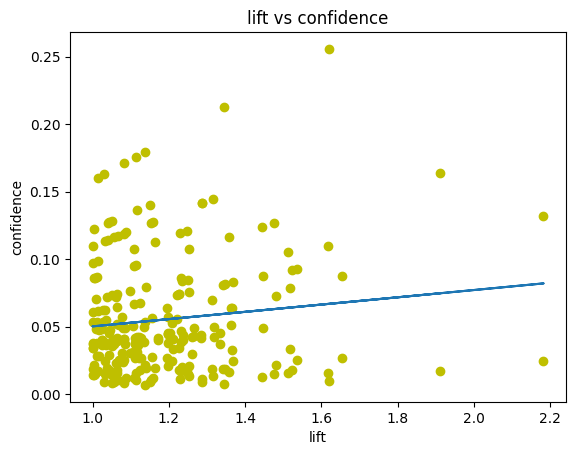

In [28]:
plot_metrics_relationship(apriori_rule_lift, col1='lift', col2='confidence')

### Confidence

In [29]:
apripri_rule = compute_association_rule(apriori_matrix, metric="confidence", min_thresh=0.2)
apripri_rule.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,"(sausage, rolls/buns)",(whole milk),0.005347,0.157923,0.001136,0.212500,1.345594,0.000292,1.069304,0.258214
1,"(sausage, yogurt)",(whole milk),0.005748,0.157923,0.001470,0.255814,1.619866,0.000563,1.131541,0.384877


# Comparative Analyzis

  
## Time execution    

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


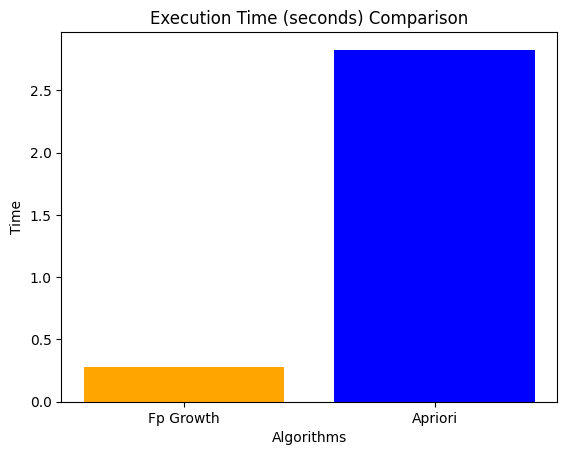

In [30]:
algo1 = ['Fp Growth', fp_growth_exec_time]
algo2 = ['Apriori', apriori_exec_time]

compare_time_exec(algo1, algo2)